In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("output_data_array.csv")
data = data.loc[:, ["melid", "bar", "beat", "target", "prediction_no_melody", "prediction_with_melody", "notes"]]
data = data.fillna("")
data

,melid,bar,beat,target,prediction_no_melody,prediction_with_melody,notes
0,1,1,1,Bb6,D7,G7,"58,58"
1,1,1,3,G7,C7,G7,
2,1,2,1,C-7,C7,C-7,
3,1,2,3,F7,F7,F7,
4,1,3,1,Bb,Bbmaj7,Bbmaj7,
...,...,...,...,...,...,...,...
29697,456,51,1,F#-7,E-7,D-7,"69,69,66"
29698,456,51,3,Fdim,B7,Fmaj7,"67,69,67,64"
29699,456,52,1,E-7,Bbmaj7,Emaj7,"66,62"
29700,456,52,3,A7,A7,Fmaj7,"64,66,69"


In [2]:
import regex as re
chord_regex = re.compile("([A-G][b#]?)(.*)")

def get_chord(str):
    root_str, type_string = chord_regex.match(str).groups()

    root = {
        "C": 0,
        "D": 2,
        "E": 4,
        "F": 5,
        "G": 7,
        "A": 9,
        "B": 11,
    }[root_str[0]]
    
    if root_str[-1] == "b":
        root -= 1
    if root_str[-1] == "#":
        root += 1

    return root, type_string

# Binary Accuracy

In [3]:
def get_binary_accs(data):
    binary_acc_baseline = len(data.loc[data["target"] == data["prediction_no_melody"]]) / len(data)
    binary_acc_melody = len(data.loc[data["target"] == data["prediction_with_melody"]]) / len(data)

    return binary_acc_baseline, binary_acc_melody

b, m = get_binary_accs(data)
print("Baseline:", b, "Melody", m)

Baseline: 0.44953201804592285 Melody 0.4737054743788297


In [4]:
acc_baseline = []
acc_melody = []

for melid, group in data.groupby("melid"):
    binary_acc_baseline, binary_acc_melody = get_binary_accs(group)
    acc_baseline.append(binary_acc_baseline)
    acc_melody.append(binary_acc_melody)

baseline = sum(acc_baseline) / len(acc_baseline)
melody = sum(acc_melody) / len(acc_melody)

baseline, melody

print("Baseline range:", max(acc_baseline), min(acc_baseline))
print("Melody range:", max(acc_melody), min(acc_melody))

Baseline range: 0.986013986013986 0.0
Melody range: 1.0 0.0


# Per Tune Improvement

In [5]:
baseline_accs = []
melody_accs = []

for melid, group in data.groupby("melid"):
    baseline_accs.append(100 * np.mean(group["prediction_no_melody"] == group["target"]))
    melody_accs.append(100 * np.mean(group["prediction_with_melody"] == group["target"]))

In [6]:
b_better = 0
b_better_amt = 0
m_better = 0
m_better_amt = 0
same = 0

for b, m in zip(baseline_accs, melody_accs):
    if b > m:
        b_better += 1
        b_better_amt += b - m
    elif m > b:
        m_better += 1
        m_better_amt += m - b
    else:
        same += 1

print("Baseline better", b_better / len(baseline_accs), "by", b_better_amt / b_better)
print("Melody better", m_better / len(baseline_accs), "by", m_better_amt / m_better)
print("Equal", same / len(baseline_accs))

Baseline better 0.3793103448275862 by 9.47515695571654
Melody better 0.496551724137931 by 11.940568124575975
Equal 0.12413793103448276


Text(0.5, 28.0, 'Baseline Model Accuracy')

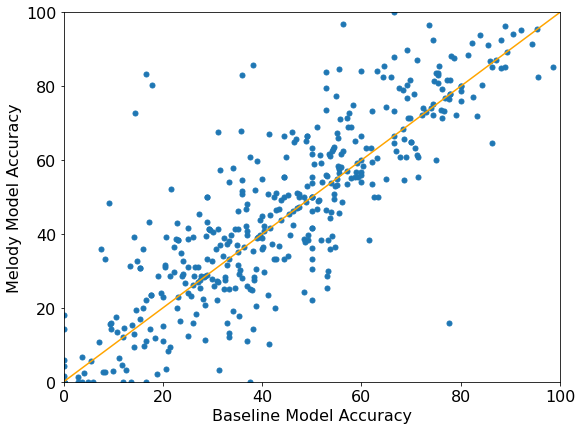

In [7]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(8, 6))

plt.tight_layout()

ax.add_line(mlines.Line2D([0, 100], [0, 100], zorder=2, color="orange"))

ax.scatter(x=baseline_accs, y=melody_accs, zorder=1, s=25)

ax.set_ylim(ymin=0, ymax=100)
ax.set_xlim(xmin=0, xmax=100)

ax.set_ylabel("Melody Model Accuracy")
ax.set_xlabel("Baseline Model Accuracy")

# Note-based Accuracies

## Binary

In [8]:
# Shift notes by 1
data_shifted = data.copy()
data_shifted["notes"] = data["notes"].shift(1).fillna("")
data_shifted["num_notes"] = data_shifted["notes"].str.count(",") + 1
data_shifted.loc[data_shifted["notes"] == "", "num_notes"] = 0

# Eliminate first row of each melid
data_shifted = data_shifted.drop(data_shifted.index[data_shifted["melid"] != data_shifted["melid"].shift(1)])
data_shifted

,melid,bar,beat,target,prediction_no_melody,prediction_with_melody,notes,num_notes
1,1,1,3,G7,C7,G7,"58,58",2
2,1,2,1,C-7,C7,C-7,,0
3,1,2,3,F7,F7,F7,,0
4,1,3,1,Bb,Bbmaj7,Bbmaj7,,0
5,1,3,3,G-7,G7,G7,,0
...,...,...,...,...,...,...,...,...
29697,456,51,1,F#-7,E-7,D-7,,0
29698,456,51,3,Fdim,B7,Fmaj7,"69,69,66",3
29699,456,52,1,E-7,Bbmaj7,Emaj7,"67,69,67,64",4
29700,456,52,3,A7,A7,Fmaj7,"66,62",2


In [9]:
print("With notes")
with_notes = get_binary_accs(data_shifted.loc[data_shifted["notes"] != ""])
print("Baseline:", with_notes[0], "Melody:", with_notes[1], "Improvement:", with_notes[1] - with_notes[0])

print("Without notes")
without = get_binary_accs(data_shifted.loc[data_shifted["notes"] == ""])
print("Baseline:", without[0], "Melody:", without[1], "Improvement:", without[1] - without[0])

With notes
Baseline: 0.4497856593265673 Melody: 0.4723921884732349 Improvement: 0.02260652914666761
Without notes
Baseline: 0.4797365754812563 Melody: 0.5177304964539007 Improvement: 0.03799392097264437


In [10]:
# Split by number of notes
for count, group in data_shifted.sort_values("num_notes").groupby("num_notes"):
    baseline, melody = get_binary_accs(group)
    print("num_notes:", count, "num_chords", len(group), "Baseline:", baseline, "Melody:", melody, "Improvement:", melody - baseline)

num_notes: 0 num_chords 1974 Baseline: 0.4797365754812563 Melody: 0.5177304964539007 Improvement: 0.03799392097264437
num_notes: 1 num_chords 1737 Baseline: 0.46862406447898675 Melody: 0.46113989637305697 Improvement: -0.007484168105929778
num_notes: 2 num_chords 2847 Baseline: 0.4636459430979979 Melody: 0.4913944502985599 Improvement: 0.02774850720056199
num_notes: 3 num_chords 3565 Baseline: 0.4875175315568022 Melody: 0.5054698457223001 Improvement: 0.017952314165497918
num_notes: 4 num_chords 4592 Baseline: 0.4686411149825784 Melody: 0.49368466898954705 Improvement: 0.02504355400696867
num_notes: 5 num_chords 2687 Baseline: 0.45738742091551915 Melody: 0.4797171566803126 Improvement: 0.022329735764793468
num_notes: 6 num_chords 2206 Baseline: 0.43880326382592927 Melody: 0.4605621033544878 Improvement: 0.021758839528558505
num_notes: 7 num_chords 2045 Baseline: 0.45330073349633254 Melody: 0.458679706601467 Improvement: 0.005378973105134466
num_notes: 8 num_chords 2255 Baseline: 0.4376

## Specific Steps

In [11]:
def has_tone(row, diff=0):
    notes = np.array(row["notes"].split(","), dtype=int) % 12
    root, _ = get_chord(row["target"])

    return (root + diff) % 12 in notes

for i in range(12):
    data_shifted[f"has_tone_{i}"] = False

for id, row in data_shifted.loc[data_shifted["notes"] != ""].iterrows():
    for i in range(12):
        data_shifted.loc[id, f"has_tone_{i}"] = has_tone(row, diff=i)

data_shifted

,melid,bar,beat,target,prediction_no_melody,prediction_with_melody,notes,num_notes,has_tone_0,has_tone_1,has_tone_2,has_tone_3,has_tone_4,has_tone_5,has_tone_6,has_tone_7,has_tone_8,has_tone_9,has_tone_10,has_tone_11
1,1,1,3,G7,C7,G7,"58,58",2,False,False,False,True,False,False,False,False,False,False,False,False
2,1,2,1,C-7,C7,C-7,,0,False,False,False,False,False,False,False,False,False,False,False,False
3,1,2,3,F7,F7,F7,,0,False,False,False,False,False,False,False,False,False,False,False,False
4,1,3,1,Bb,Bbmaj7,Bbmaj7,,0,False,False,False,False,False,False,False,False,False,False,False,False
5,1,3,3,G-7,G7,G7,,0,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29697,456,51,1,F#-7,E-7,D-7,,0,False,False,False,False,False,False,False,False,False,False,False,False
29698,456,51,3,Fdim,B7,Fmaj7,"69,69,66",3,False,True,False,False,True,False,False,False,False,False,False,False
29699,456,52,1,E-7,Bbmaj7,Emaj7,"67,69,67,64",4,True,False,False,True,False,True,False,False,False,False,False,False
29700,456,52,3,A7,A7,Fmaj7,"66,62",2,False,False,False,False,False,True,False,False,False,True,False,False


In [12]:
improvement_diffs = [0] * 12
baseline_nos = [0] * 12
melody_nos = [0] * 12
diff_nos = [0] * 12

baseline_withs = [0] * 12
melody_withs = [0] * 12
diff_withs = [0] * 12

for i in range(12):
    print(f"No tone +{i}")
    baseline_nos[i], melody_nos[i] = get_binary_accs(data_shifted.loc[~data_shifted[f"has_tone_{i}"]])
    diff_nos[i] = melody_nos[i] - baseline_nos[i]
    print("Baseline:", baseline_nos[i], "Melody:", melody_nos[i], "Improvement:", diff_nos[i])

    print(f"With tone +{i}")
    baseline_withs[i], melody_withs[i] = get_binary_accs(data_shifted.loc[data_shifted[f"has_tone_{i}"]])
    diff_withs[i] = melody_withs[i] - baseline_withs[i]
    print("Baseline:", baseline_withs[i], "Melody:", melody_withs[i], "Improvement:", diff_withs[i])

    improvement_diffs[i] = diff_withs[i] - diff_nos[i]
    print("DIFF (melody_improvement - baseline_improvement):", improvement_diffs[i])

No tone +0
Baseline: 0.4500683215668413 Melody: 0.4728421771805967 Improvement: 0.02277385561375539
With tone +0
Baseline: 0.45441339827394683 Melody: 0.47936426557293 Improvement: 0.02495086729898316
DIFF (melody_improvement - baseline_improvement): 0.00217701168522777
No tone +1
Baseline: 0.47043177586665486 Melody: 0.49255253125277065 Improvement: 0.022120755386115798
With tone +1
Baseline: 0.389178715158742 Melody: 0.4179460426293039 Improvement: 0.028767327470561932
DIFF (melody_improvement - baseline_improvement): 0.006646572084446134
No tone +2
Baseline: 0.43685358081288084 Melody: 0.4646391233856991 Improvement: 0.02778554257281829
With tone +2
Baseline: 0.4753075571177504 Melody: 0.4924428822495606 Improvement: 0.01713532513181021
DIFF (melody_improvement - baseline_improvement): -0.01065021744100808
No tone +3
Baseline: 0.47688910696761533 Melody: 0.49602551521099114 Improvement: 0.019136408243375813
With tone +3
Baseline: 0.3942837853043772 Melody: 0.42826600652638686 Improv

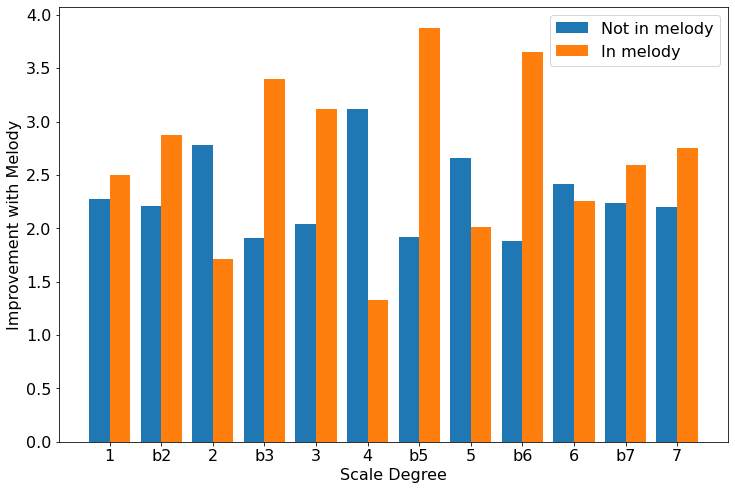

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4

b1 = ax.bar(np.arange(12), np.array(diff_nos) * 100, width=bar_width, label="Not in melody")
b2 = ax.bar(np.arange(12) + bar_width, np.array(diff_withs) * 100, width=bar_width, label="In melody")

ax.set_xticks(np.arange(12) + bar_width / 2)
ax.set_xticklabels(["1", "b2", "2", "b3", "3", "4", "b5", "5", "b6", "6", "b7", "7"])

ax.set_ylabel("Improvement with Melody")
ax.set_xlabel("Scale Degree")
ax.legend()

Text(0.5, 0, 'Scale Degree')

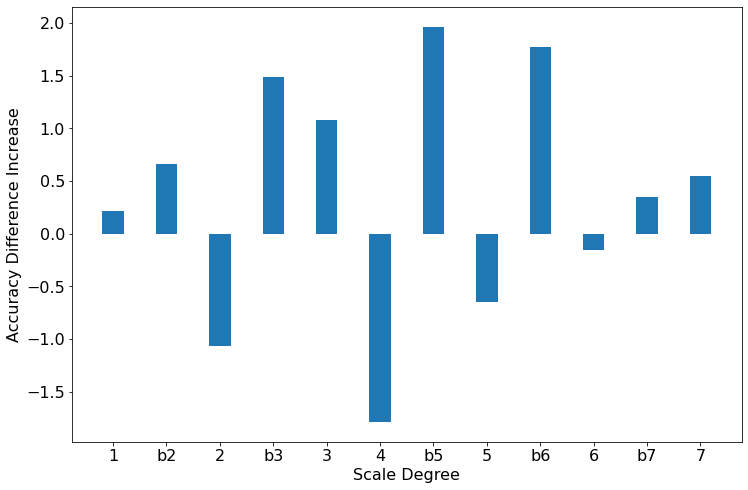

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

b1 = ax.bar(np.arange(12), np.array(improvement_diffs) * 100, width=bar_width)

ax.set_xticks(np.arange(12))
ax.set_xticklabels(["1", "b2", "2", "b3", "3", "4", "b5", "5", "b6", "6", "b7", "7"])

ax.set_ylabel("Accuracy Difference Increase")
ax.set_xlabel("Scale Degree")

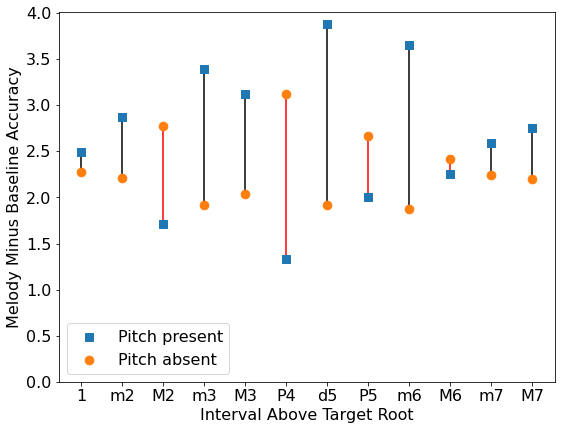

In [15]:
import matplotlib.lines as mlines
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(8, 6))

plt.tight_layout()

for x, (no, yes) in enumerate(zip(diff_nos, diff_withs)):
    ax.add_line(mlines.Line2D([x / 2, x / 2], [no * 100, yes * 100], color='black' if yes > no else 'red', zorder=1))

ax.scatter(x=np.arange(12) / 2, y=np.array(diff_withs) * 100, label="Pitch present", zorder=2, s=75, marker="s")
ax.scatter(x=np.arange(12) / 2, y=np.array(diff_nos) * 100, label="Pitch absent", zorder=2, s=75)

ax.set_xticks(np.arange(12) / 2)
ax.set_xticklabels(["1", "m2", "M2", "m3", "M3", "P4", "d5", "P5", "m6", "M6", "m7", "M7"])

ax.set_ylim(ymin=0)

ax.set_ylabel("Melody Minus Baseline Accuracy")
ax.set_xlabel("Interval Above Target Root")
ax.legend()

### Looking at Following Chords

In [16]:
data_shifted["target_type"] = ""
data_shifted["target_root"] = ""
data_shifted["baseline_type"] = ""
data_shifted["baseline_root"] = ""
data_shifted["melody_type"] = ""
data_shifted["melody_root"] = ""

for id, row in data_shifted.iterrows():
    data_shifted.loc[id, "target_root"], data_shifted.loc[id, "target_type"] = chord_regex.match(row["target"]).groups()
    data_shifted.loc[id, "baseline_root"], data_shifted.loc[id, "baseline_type"] = chord_regex.match(row["prediction_no_melody"]).groups()
    data_shifted.loc[id, "melody_root"], data_shifted.loc[id, "melody_type"] = chord_regex.match(row["prediction_with_melody"]).groups()

# Confusion Matrix

In [17]:
data["target_type"] = ""
data["target_root"] = ""
data["baseline_type"] = ""
data["baseline_root"] = ""
data["melody_type"] = ""
data["melody_root"] = ""

for id, row in data.iterrows():
    data.loc[id, "target_root"], data.loc[id, "target_type"] = chord_regex.match(row["target"]).groups()
    data.loc[id, "baseline_root"], data.loc[id, "baseline_type"] = chord_regex.match(row["prediction_no_melody"]).groups()
    data.loc[id, "melody_root"], data.loc[id, "melody_type"] = chord_regex.match(row["prediction_with_melody"]).groups()

In [18]:
chord_types = ["7", "-7", "maj7", "", "m7b5", "-", "6", "sus47", "-6", "dim", "sus4", "7#5", "dim7", "-maj7", "+", "7+"]
baseline = np.zeros((13, len(chord_types), len(chord_types) + 1))
melody = np.zeros((13, len(chord_types), len(chord_types) + 1))

data_tmp = data_shifted

for id, row in data_tmp.iterrows():
    x = chord_types.index(row["target_type"])
    if row["baseline_root"] != row["target_root"]:
        baseline_y = -1
    else:
        baseline_y = chord_types.index(row["baseline_type"])
    if row["melody_root"] != row["target_root"]:
        melody_y = -1
    else:
        melody_y = chord_types.index(row["melody_type"])

    baseline[0, x, baseline_y] += 1
    melody[0, x, melody_y] += 1

    for tone in range(12):
        if row[f"has_tone_{tone}"]:
            baseline[tone + 1, x, baseline_y] += 1
            melody[tone + 1, x, melody_y] += 1

baseline_norm = baseline / np.sum(baseline, axis=2, keepdims=True)
melody_norm = melody / np.sum(melody, axis=2, keepdims=True)

<ipython-input-18-32216e2e2055>:26: RuntimeWarning: invalid value encountered in true_divide
  baseline_norm = baseline / np.sum(baseline, axis=2, keepdims=True)
<ipython-input-18-32216e2e2055>:27: RuntimeWarning: invalid value encountered in true_divide
  melody_norm = melody / np.sum(melody, axis=2, keepdims=True)


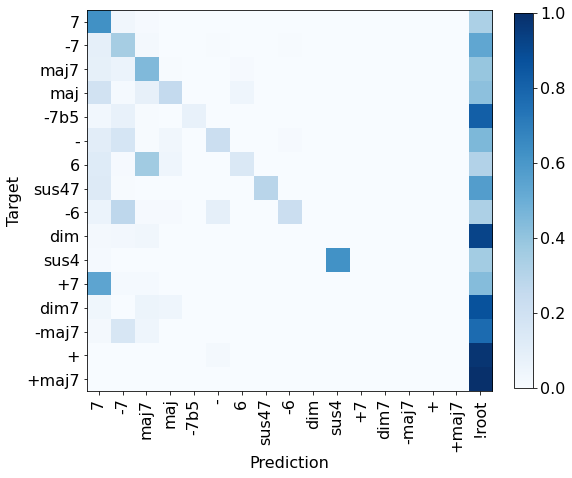

In [19]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(8, 8))

chord_type_labels = ["7", "-7", "maj7", "maj", "-7b5", "-", "6", "sus47", "-6", "dim", "sus4", "+7", "dim7", "-maj7", "+", "+maj7"]

im = ax.imshow(baseline_norm[0], cmap="Blues", vmin=0.0, vmax=1.0)

ax.set_yticks(np.arange(len(chord_types)))
ax.set_xticks(np.arange(len(chord_types) + 1))

ax.set_yticklabels(chord_type_labels)
ax.set_xticklabels(chord_type_labels + ["!root"], rotation=90)

ax.set_ylabel("Target")
ax.set_xlabel("Prediction")

fig.colorbar(im,fraction=0.042)

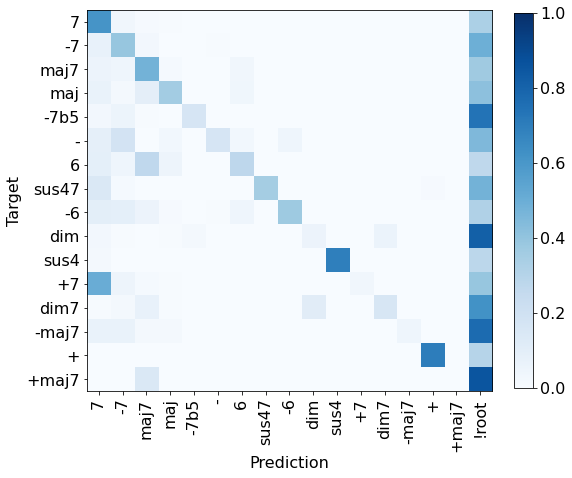

In [20]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(melody_norm[0], cmap="Blues", vmin=0.0, vmax=1.0)

ax.set_yticks(np.arange(len(chord_types)))
ax.set_xticks(np.arange(len(chord_types) + 1))

ax.set_yticklabels(chord_type_labels)
ax.set_xticklabels(chord_type_labels + ["!root"], rotation=90)

ax.set_ylabel("Target")
ax.set_xlabel("Prediction")

fig.colorbar(im,fraction=0.042)

Text(0.5, 46.0, 'Prediction')

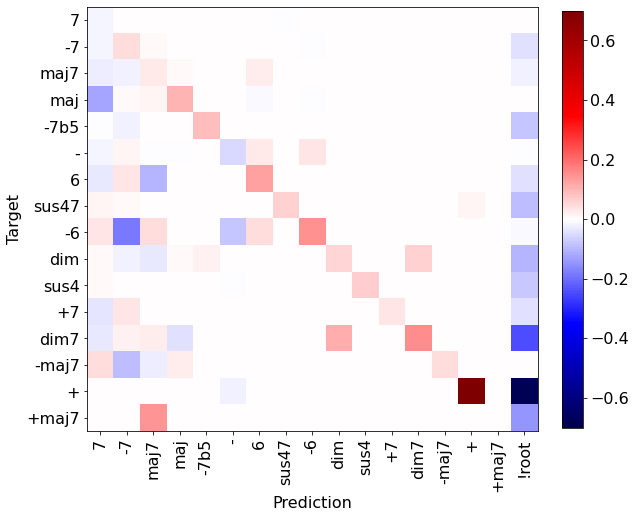

In [21]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(8, 8))

plt.tight_layout()

im = ax.imshow(melody_norm[0] - baseline_norm[0], cmap="seismic", vmin=-0.7, vmax=0.7)
fig.colorbar(im,fraction=0.042)

ax.set_yticks(np.arange(len(chord_types)))
ax.set_xticks(np.arange(len(chord_types) + 1))

ax.set_yticklabels(chord_type_labels)
ax.set_xticklabels(chord_type_labels + ["!root"], rotation=90)

ax.set_ylabel("Target")
ax.set_xlabel("Prediction")

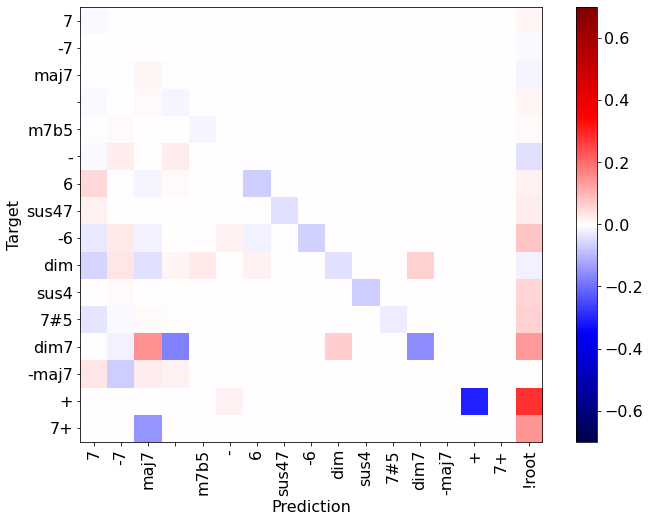

In [22]:
TONE = 5

fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(
    (melody_norm[TONE + 1] - baseline_norm[TONE + 1]) - (melody_norm[0] - baseline_norm[0]),
    cmap="seismic", vmin=-0.7, vmax=0.7
)

ax.set_yticks(np.arange(len(chord_types)))
ax.set_xticks(np.arange(len(chord_types) + 1))

ax.set_yticklabels(chord_types)
ax.set_xticklabels(chord_types + ["!root"], rotation=90)

ax.set_ylabel("Target")
ax.set_xlabel("Prediction")

fig.colorbar(im)

In [23]:
TONE = 6

counts = np.sum(melody, axis=2)[TONE + 1]
base_counts = np.sum(melody, axis=2)[0]

list(zip(chord_types, base_counts/sum(base_counts), counts / sum(counts), counts/sum(counts) - base_counts/sum(base_counts)))

[('7', 0.45399255133768407, 0.4354573944187435, -0.018535156918940587),
 ('-7', 0.2331636313937199, 0.2463811371437099, 0.013217505749990005),
 ('maj7', 0.10810810810810811, 0.09744814206834801, -0.010659966039760105),
 ('', 0.04404277855605289, 0.037606327413818835, -0.006436451142234054),
 ('m7b5', 0.037004134349267095, 0.057155648410684975, 0.02015151406141788),
 ('-', 0.026275327160282913, 0.025667810774511267, -0.0006075163857716462),
 ('6', 0.024737759251033588, 0.017161617669004627, -0.007576141582028961),
 ('sus47', 0.018074964977619845, 0.020444709744814205, 0.00236974476719436),
 ('-6', 0.014692315577271329, 0.009849276227428741, -0.0048430393498425876),
 ('dim', 0.011275498001161718, 0.021340098492762274, 0.010064600491600555),
 ('sus4', 0.010352957255612123, 0.009700044769437397, -0.0006529124861747258),
 ('7#5', 0.008234530358424164, 0.006416952693627817, -0.0018175776647963472),
 ('dim7', 0.006696962449174839, 0.01268467392926429, 0.0059877114800894506),
 ('-maj7',
  0.00

In [24]:
tones = [-1]
chords = ["-", "-7"]

melody_correct = 0
melody_total = 0
baseline_correct = 0
baseline_total = 0

for i, chord in enumerate(chord_types):
    if chord in chords:
        for tone in tones:
            melody_correct += melody[tone + 1][i][i]
            melody_total += sum(melody[tone + 1][i])

            baseline_correct += baseline[tone + 1][i][i]
            baseline_total += sum(baseline[tone + 1][i])

print("Diff =", melody_correct/melody_total - baseline_correct/baseline_total)

Diff = 0.034768866060845505


In [25]:
tone = 6
chord = "dim7"

print("Melody with:", melody_norm[tone + 1][chord_types.index(chord)][chord_types.index(chord)], "overall:", melody_norm[0][chord_types.index(chord)][chord_types.index(chord)])
print("Baseline with:", baseline_norm[tone + 1][chord_types.index(chord)][chord_types.index(chord)], "overall:", baseline_norm[0][chord_types.index(chord)][chord_types.index(chord)])

Melody with: 0.16470588235294117 overall: 0.15816326530612246
Baseline with: 0.0 overall: 0.0


# Target Type Counts

Text(0.5, 24.3, 'Count')

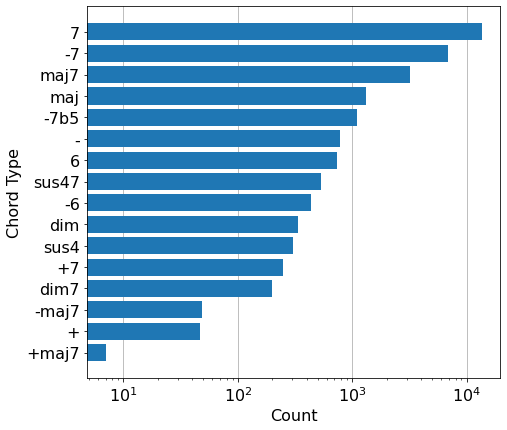

In [33]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(7,6))

plt.semilogx()
plt.tight_layout()

counts = list(data["target_type"].value_counts())
labels = list(data["target_type"].value_counts().index)

labels[3] = "maj"
labels[4] = "-7b5"
labels[-5] = "+7"
labels[-1] = "+maj7"

b1 = ax.barh(np.arange(len(labels)) / 2, list(reversed(counts)), height=0.4, zorder=2)

ax.set_yticks(np.arange(len(labels)) / 2)
ax.set_yticklabels(list(reversed(labels)))

ax.grid(axis = 'x', zorder=1)

ax.set_ylabel("Chord Type")
ax.set_xlabel("Count")

# Finding Examples

In [27]:
data_shifted.loc[
    (
        data_shifted["has_tone_5"]
        & (data_shifted["prediction_no_melody"] == data_shifted["target"])
        & (data_shifted["prediction_with_melody"] != data_shifted["target"])
        & data_shifted["target"].str.endswith("-")
        & data_shifted["prediction_with_melody"].str.endswith("6")
    ),
    [
        "melid",
        "bar",
        "beat",
        "target",
        "prediction_no_melody",
        "prediction_with_melody",
    ]
]

,melid,bar,beat,target,prediction_no_melody,prediction_with_melody
27449,419,24,1,C-,C-,C-6
27500,419,48,1,C-,C-,C-6


In [29]:
data_shifted.loc[(data_shifted["melid"] == 419) & data_shifted["bar"].isin([23, 24]), ["prediction_no_melody", "prediction_with_melody", "target"]]

,prediction_no_melody,prediction_with_melody,target
27447,C-,C7,Dm7b5
27448,G7,G7,G7
27449,C-,C-6,C-
27450,C-,Dm7b5,G7


In [28]:
data_shifted.loc[
    (
        data_shifted["has_tone_6"]
        & (data_shifted["prediction_no_melody"] != data_shifted["target"])
        & (data_shifted["prediction_with_melody"] == data_shifted["target"])
        & data_shifted["target"].str.contains("dim")
    ),
    [
        "melid",
        "bar",
        "beat",
        "target",
        "prediction_no_melody",
        "prediction_with_melody",
    ]
]

,melid,bar,beat,target,prediction_no_melody,prediction_with_melody
7543,118,4,3,Edim7,Bb7,Edim7
7560,118,12,3,Edim7,Bb7,Edim7
7623,119,-2,3,Ebdim,A-7,Ebdim
8639,132,3,1,Bdim,Bb7,Bdim
8645,132,11,1,Bdim,G7,Bdim
13302,205,13,1,Dbdim7,Dbmaj7,Dbdim7
13320,205,29,1,Dbdim7,Dbmaj7,Dbdim7
13364,206,4,3,Edim7,Bb7,Edim7
13381,206,12,3,Edim7,Bb7,Edim7
22612,342,212,1,Bdim7,F-7,Bdim7


In [30]:
data_shifted.loc[(data_shifted["melid"] == 205) & data_shifted["bar"].isin([12, 13]), ["prediction_no_melody", "prediction_with_melody", "target"]]

,prediction_no_melody,prediction_with_melody,target
13301,Ab7,Ab7,Ab7
13302,Dbmaj7,Dbdim7,Dbdim7
13303,Db6,Db6,Db6
